## 🐬 Описание проекта


*   Исследование проводилось для кадрового агентства, предоставившего данные по закрытию вакансий за период 2023 - начало 2024 года.
*   Цель (формулировка в ТЗ)
Выявить признаки вакансий, привлекающих наибольшее внимание кандидатов и успешно закрывающихся силами агентства. В рамках выполнения данной задачи можно использовать любые методы и средства, даже если они не описаны в ТЗ.







## 🪼В этом ноутбуке продолжение [исследований](https://docs.google.com/spreadsheets/d/1HjNH6JRjQz9TJ_6DcXCofrh4xAIzBE84/edit?usp=drive_link&ouid=108036727568364940970&rtpof=true&sd=true), проведенных Марией и попытка немного по-другому обработать категориальные и текстовые признаки

Основные отличия:
- мультилейбл для типа занятости, образования, опыта и формата работы
- уменьшение числа уникальных значений для городов
- убрать курсы из признаков (насколько можно понять - это служебная информация, которую кандидат не видит)
- tiny bert  вместо bert. В дальнейшем можно попробовать прикрутить суммаризацию, чтобы исключить повторы
- тестовое задание - есть/нет
- для названия позиции введена дополнительная фича - грейд
- метод кластеризации по профессиям -  оставлен ручной с небольшими модификациями
- города - разделены на наиболее крупные и все остальные, исключены неявные дубликаты

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.1 MB/s eta 0:00:00


In [3]:
!pip -q install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 452.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import pandas as pd
import warnings
import re
import os
import numpy as np
import torch
from tqdm import tqdm
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import pymorphy2
from pymorphy2 import MorphAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import joblib
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from pymystem3 import Mystem


import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


RANDOM_STATE = 2004
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')

sns.set(style='darkgrid', font_scale=1.2)

In [5]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import names, stopwords, words
from wordcloud import WordCloud, STOPWORDS
STOPWORDS = set(stopwords.words('russian'))
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## 🐚 Загрузка данных

In [59]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/vacancies/vacancy_statistics_2023.xlsx', index_col=False)

In [60]:
df.sample(5)

,id,Статус,Источник лида,Менеджер,Дата публикации,Дата закрытия,Количество просмотров,Количество откликов,Компания,Позиция,Курсы ЯП,Зарплата от,Зарплата до,Город,Формат оформления,Формат работы,Опыт,Образование,Ссылка на тестовое,Занятость,Обязательные требования,Дополнительный требования,Этапы отбора,Условия
1179,1908,Архив,Сорсинг,Фаткуллин,2023-11-07,2023-11-29,103,2,Crezu,QA Engineer,"QA Bootcamp, Инженер по тестированию Плюс, Инж...",NaN,NaN,Москва,"Самозанятость, Контракт, ИП, ГПХ",Удаленка,"Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",https://crezu.notion.site/QA-cd4a7e0563a3412cb...,Полная,Опыт работы в тестировании веб-сервисов и знан...,"Будет плюсом, если вы:_x000D_\n_x000D_\nИмели ...",1. Тестовое по ссылке_x000D_\nhttps://crezu.no...,Удаленную работу на full-time;_x000D_\n28 кале...
84,385,Отклонена,Сорсинг,Фаткуллин,2023-01-30,2023-04-10,48,18,ПАО Росбанк,"Дизайнер (графика, UX/UI)","Дизайнер интерфейсов, Графический дизайнер",NaN,120000.0,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой дог...","Офис, Удаленка","Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,Полная,"Строго: работа с Автолэйаутами, понимание того...",Умение проводить интервью. В банке есть свой о...,1. Скрининг резюме _x000D_\n2. Личное общение ...,ВАЖНО! _x000D_\n- Для мужчин - наличие военног...
649,1169,Закрыта нами,Повторная,Фаткуллин,2023-07-04,2023-09-14,59,38,Antipoff Group,Frontend-разработчик,"Web Bootcamp, React-разработчик, Веб-Разработч...",NaN,NaN,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой дог...",Удаленка,"Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,"Частичная, Полная",Опорные знания и навыки:_x000D_\n🔹 Знание Reac...,Будет плюсом:_x000D_\n- Опыт работы с TypeScri...,1. Отклик в трекере _x000D_\n2. Заполнение анк...,Опыт работы: от 1 года / Если недостаточно оп...
262,608,Архив,Повторная,Иванова,2023-03-28,2023-05-23,28,9,Корпоративный Маркетинг,Аналитик данных (нейросети),"Специалист по Data Science, Специалист по Data...",120000.0,NaN,Москва,Трудовой договор,Офис,"Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,Полная,- Уверенные знания SQL и опыт работы с базами ...,Желателен опыт написания процессов загрузки да...,Скрининг _x000D_\nИнтервью,- Официальное оформление_x000D_\n- Заработная ...
300,661,Архив,Входящая заявка,Корягина,2023-04-10,2023-06-08,20,10,YOLES,IT Recruiter,IT-рекрутер,80000.0,NaN,Москва,"Самозанятость, ИП",Удаленка,"Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,Полная,Требования обязательные: _x000D_\n_x000D_\n— ...,Требования необязательные: _x000D_\n_x000D_\n—...,1. Просмотр резюме;_x000D_\n2. Тестовое задани...,Условия: _x000D_\n_x000D_\n— Трудоустройство к...


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1302 non-null   int64  
 1   Статус                     1302 non-null   object 
 2   Источник лида              1292 non-null   object 
 3   Менеджер                   1209 non-null   object 
 4   Дата публикации            1302 non-null   object 
 5   Дата закрытия              1144 non-null   object 
 6   Количество просмотров      1302 non-null   int64  
 7   Количество откликов        1302 non-null   int64  
 8   Компания                   1302 non-null   object 
 9   Позиция                    1302 non-null   object 
 10  Курсы ЯП                   1302 non-null   object 
 11  Зарплата от                476 non-null    float64
 12  Зарплата до                377 non-null    float64
 13  Город                      1302 non-null   objec

In [65]:
df=df.rename(columns={'Статус':'status', 'Источник лида':'lead_source', 'Менеджер':'manager', 'Дата публикации':'start_date', 'Дата закрытия':'end_date', 'Количество просмотров':'views',
'Количество откликов':'responses', 'Компания':'emp_brand',  'Позиция':'job_title', 'Курсы ЯП':'courses','Зарплата от':'salary_min', 'Зарплата до':'salary_max', 'Город':'city', 'Формат оформления':'contract', 'Формат работы':'format', 'Опыт':'experience', 'Образование':'education', 'Занятость':'employment', 'Ссылка на тестовое':'test_task', 'Обязательные требования':'mandatory', 'Дополнительный требования':'additional', 'Этапы отбора':'comр_stages', 'Условия':'work_conditions'
})

In [66]:
df['target'] = df['responses'] / df['views']

In [67]:
df['test_task'] = df['test_task'].apply(lambda x: 1 if (x is not None) else 0)

In [68]:
df = df.drop(columns=['id','status','lead_source','manager', 'start_date', 'end_date', 'views', 'responses', 'courses'], axis=1)

In [69]:
df['emp_brand'] = df['emp_brand'].apply(lambda x: x.lower().strip())

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   emp_brand        1302 non-null   object 
 1   job_title        1302 non-null   object 
 2   salary_min       476 non-null    float64
 3   salary_max       377 non-null    float64
 4   city             1302 non-null   object 
 5   contract         1302 non-null   object 
 6   format           1302 non-null   object 
 7   experience       1302 non-null   object 
 8   education        1302 non-null   object 
 9   test_task        1302 non-null   int64  
 10  employment       1302 non-null   object 
 11  mandatory        1302 non-null   object 
 12  additional       674 non-null    object 
 13  comр_stages      1302 non-null   object 
 14  work_conditions  1302 non-null   object 
 15  target           1302 non-null   float64
dtypes: float64(3), int64(1), object(12)
memory usage: 162.9+ KB


## 🦈 Профессии и грейды

In [71]:
def grade(txt: str) -> str:
    grds = ['intern', 'juniour', 'middle', 'senior', 'lead']
    patterns = [['intern', 'интерн', 'стаж', 'ассист', 'помощ'],
                ['juni', 'младш', 'джун'],
                 ['middle', 'мидл', 'средн'],
                 ['senior', 'сеньор', 'старш'],
                  ['lead', 'ведущ', 'тимлид']]
    result = 'unknown'
    for g, p in zip(grds, patterns):
        matches = [x for x in p if x in txt.lower()]
        if len(matches) != 0:
            result = g
            pass # first match
    return result

In [72]:
df['grade'] = df['job_title'].apply(grade)

<Axes: >

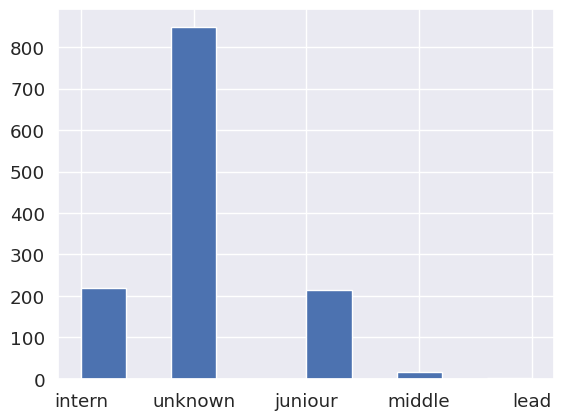

In [73]:
df['grade'].hist()

In [74]:
def prof(txt: str) -> str:
    profs = ['developer', 'devops', 'ds', 'analyst', 'manager',
             'tester', 'designer', 'marketolog', 'support', 'hr']
    patterns = [['develop', 'разработ', 'программист'],
                ['devops', 'ops'],
                 ['ds', 'scien', 'саен', 'сайен', 'ml', 'nlp', 'машин'],
                 ['аналит', 'analyst', 'данны'],
                  ['pm', 'менеджер', 'руководитель', 'manager', 'куратор', 'администр'],
                ['качеств', 'тест', 'test', 'qa'],
                ['design', 'ux', 'ui', 'дизайн'],
                ['таргет', 'market', 'маркет', 'контекст', 'smm', 'seo'],
                ['support', 'техподдер', 'поддерж', 'забот'],
                ['recruit', 'hr', 'сорсер', 'рекрут', 'ресечер', 'рисерчер']]
    result = 'other'
    for pr, pt in zip(profs, patterns):
        matches = [x for x in pt if x in txt.lower()]
        if len(matches) != 0:
            result = pr
            pass
    return result

In [75]:
df['profession'] = df['job_title'].apply(prof)

In [76]:
df = df.drop(['job_title'], axis=1)

## 🐙 Города

Строго говоря, сюда надо подтягивать geopandas и geonames. Пока что в качестве временной меры сделаем категории Москва, СПб, Екб и все остальное

In [77]:
def outside_the_mkad(txt: str) -> str:
    patterns = [['москв', 'маскв', 'москов'],
                ['петерб', 'санкт', 'спб', 'питер'],
                ['екб', 'екатеринб']]
    cities = ['MOW', 'LED', 'SVX']
    result = 'other'
    for c, pt in zip(cities, patterns):
        matches = [x for x in pt if x in txt.lower()]
        if len(matches) != 0:
            result = c
            pass
    return result

In [78]:

df['location'] = df['city'].apply(outside_the_mkad)

<Axes: >

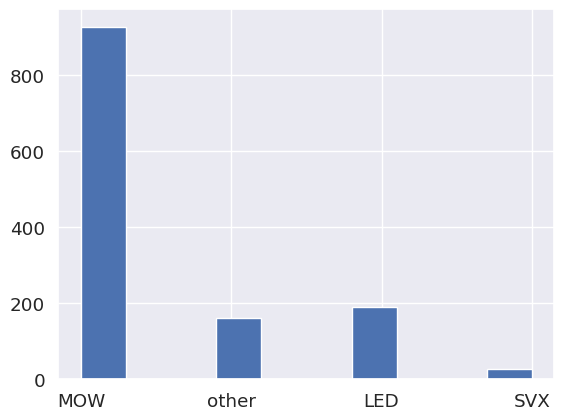

In [79]:
df['location'].hist()

In [80]:
df = df.drop(['city'], axis=1)

## 🪸 Опыт, образования, условия работы

In [81]:
def labels(data: pd.DataFrame, column: str):
    vals = data[column].unique()
    all_vals = ','.join(list(vals))
    all_vals = re.sub(r'\((.*?)\)', r'', all_vals).split(',')
    all_vals = list(map(lambda x: x.strip(), all_vals))
    un_vals = list(set(all_vals))
    for u in un_vals:
        data[u] = data[column].apply(lambda x: 1 if u in x else 0)

In [82]:
labels(df, 'experience')

In [83]:
df = df.rename(columns={'Релевантный': 'relevant_exp',
                   'Около-релевантный': 'near_exp',
                   'Есть только учебный опыт в Практикуме': 'student_exp'})
df = df.drop(['experience'], axis=1)

In [84]:
labels(df, 'education')

In [85]:
df = df.rename(columns={'Профильное': 'relevant_edu',
                   'Около-релевантное': 'near_edu',
                   'Другое': 'other_edu'})
df = df.drop(['education'], axis=1)

In [86]:
labels(df, 'format')

In [87]:
labels(df, 'contract')

In [88]:
df = df.rename(columns={'Удаленка': 'remote',
                   'Офис': 'office',
                   'Гибрид': 'hybrid',
                        'ГПХ': 'gph',
                        'Контракт': 'temporary',
                        'Трудовой договор': 'permanent',
                        'Самозанятость': 'self_empl',
                        'ИП': 'ind_enterp'})
df = df.drop(['format', 'contract'], axis=1)

In [89]:
labels(df, 'employment')

In [90]:
df = df.rename(columns={'Проектная': 'project',
                   'Частичная': 'part_time',
                   'Полная': 'full_time',
                        'Стажировка': 'internship',
                        'Волонтерство': 'volunteering'})
df = df.drop(['employment'], axis=1)

## 🐡 Заполнение пропусков

In [91]:
df['additional']= df['additional'].fillna(' или ')

In [93]:
# df['salary_min'] = df.groupby("profession")['salary_min'].transform(lambda x: x.fillna(x.median()))
# df['salary_max'] = df.groupby("profession")['salary_max'].transform(lambda x: x.fillna(x.median()))

In [94]:
df['description'] = df['mandatory'] + df['additional'] + df['comр_stages'] + df['work_conditions']
df = df.drop(['mandatory', 'additional', 'comр_stages', 'work_conditions'], axis=1)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   emp_brand     1302 non-null   object 
 1   salary_min    476 non-null    float64
 2   salary_max    1302 non-null   float64
 3   test_task     1302 non-null   int64  
 4   target        1302 non-null   float64
 5   grade         1302 non-null   object 
 6   profession    1302 non-null   object 
 7   location      1302 non-null   object 
 8   near_exp      1302 non-null   int64  
 9   student_exp   1302 non-null   int64  
 10  relevant_exp  1302 non-null   int64  
 11  other_edu     1302 non-null   int64  
 12  near_edu      1302 non-null   int64  
 13  relevant_edu  1302 non-null   int64  
 14  office        1302 non-null   int64  
 15  remote        1302 non-null   int64  
 16  hybrid        1302 non-null   int64  
 17  permanent     1302 non-null   int64  
 18  self_empl     1302 non-null 

## 🦭 Text Processing (Tiny Bert)

---



In [96]:
def cleaner(txt: str) -> str:
    txt = re.sub(r'\_(.*?)\_', r'', txt)
    txt = re.sub(r'([\n\t]*)', r'', txt)
    return txt

In [97]:
example = df['description'][154]
print(example)
print('_'*50)
cleaner(example)

Кого мы ищем:_x000D_
_x000D_
- Мистера или Мисс Обаяние, самого очаровательного рекрутера;_x000D_
- Настойчивого, но ненавязчивого, любящего людей человека;_x000D_
- Рекрутера с опытом в подборе ИЛИ кандидата без опыта, жаждущего влиться в новый увлекательный мир IT-подбора;_x000D_
- Разговорный английский от B1-B2 обязателен. или - Телефонный созвон с HRD _x000D_
- Интервью в zoom с командой_x000D_
Если тебя заинтересовала наша вакансия, пожалуйста, расскажи о своем самом большом профессиональном достижении в сопроводительном письме.- Мы не берем в работу неконкурентоспособные вакансии. - Никаких зарплат ниже рынка, скучных задач и мертвых стеков. _x000D_
- Удаленка, оплата в долларах, релокейт - мы выбираем только такие позиции;_x000D_
- Возможность познакомиться с системами подбора лучших компаний мира;_x000D_
- Мы обучаем сами и привлекаем спикеров со стороны, чтобы усилить скиллы наших рекрутеров;_x000D_
- Мы достойно оплачиваем работу: рекрутер получает оклад, а также от 10 до 25

'Кого мы ищем:- Мистера или Мисс Обаяние, самого очаровательного рекрутера;- Настойчивого, но ненавязчивого, любящего людей человека;- Рекрутера с опытом в подборе ИЛИ кандидата без опыта, жаждущего влиться в новый увлекательный мир IT-подбора;- Разговорный английский от B1-B2 обязателен. или - Телефонный созвон с HRD - Интервью в zoom с командойЕсли тебя заинтересовала наша вакансия, пожалуйста, расскажи о своем самом большом профессиональном достижении в сопроводительном письме.- Мы не берем в работу неконкурентоспособные вакансии. - Никаких зарплат ниже рынка, скучных задач и мертвых стеков. - Удаленка, оплата в долларах, релокейт - мы выбираем только такие позиции;- Возможность познакомиться с системами подбора лучших компаний мира;- Мы обучаем сами и привлекаем спикеров со стороны, чтобы усилить скиллы наших рекрутеров;- Мы достойно оплачиваем работу: рекрутер получает оклад, а также от 10 до 25% от оклада нанятого разработчика;- Полностью удаленная работа;- Мы веселые и экологичн

In [98]:
df['description'] = df['description'].apply(cleaner)

In [99]:
df['seqlen'] = df['description'].apply(lambda x: len(x))
q1 = df['seqlen'].quantile(.05)
q2 = df['seqlen'].quantile(.95)
df = df.loc[(df['seqlen'] > q1) & (df['seqlen'] < q2)]
df['seqlen'].describe()

count    1170.000000
mean      823.358974
std       297.216041
min       307.000000
25%       583.000000
50%       796.000000
75%      1054.000000
max      1488.000000
Name: seqlen, dtype: float64

In [100]:
df = df.drop(['seqlen'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1170 entries, 0 to 1301
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   emp_brand     1170 non-null   object 
 1   salary_min    425 non-null    float64
 2   salary_max    1170 non-null   float64
 3   test_task     1170 non-null   int64  
 4   target        1170 non-null   float64
 5   grade         1170 non-null   object 
 6   profession    1170 non-null   object 
 7   location      1170 non-null   object 
 8   near_exp      1170 non-null   int64  
 9   student_exp   1170 non-null   int64  
 10  relevant_exp  1170 non-null   int64  
 11  other_edu     1170 non-null   int64  
 12  near_edu      1170 non-null   int64  
 13  relevant_edu  1170 non-null   int64  
 14  office        1170 non-null   int64  
 15  remote        1170 non-null   int64  
 16  hybrid        1170 non-null   int64  
 17  permanent     1170 non-null   int64  
 18  self_empl     1170 non-null   int

In [101]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

def embed_bert_cls(text):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls(example).shape)

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

(312,)


In [44]:
emb_result = np.array(list(map(lambda x: 'emb_' + str(x), range(312))))
emb_result = np.expand_dims(emb_result, axis=0)
for data in tqdm(df['description'].values, desc='Creating embeddings'):
    res = np.expand_dims(embed_bert_cls(data), axis=0)
    emb_result = np.concatenate((emb_result, res), axis=0)

Creating embeddings: 100%|██████████| 1170/1170 [01:25<00:00, 13.61it/s]


In [45]:
emb_result.shape

(1171, 312)

In [46]:
dfe = pd.DataFrame(data=emb_result[1:,:], columns=emb_result[0,:])
dfe.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198,emb_199,emb_200,emb_201,emb_202,emb_203,emb_204,emb_205,emb_206,emb_207,emb_208,emb_209,emb_210,emb_211,emb_212,emb_213,emb_214,emb_215,emb_216,emb_217,emb_218,emb_219,emb_220,emb_221,emb_222,emb_223,emb_224,emb_225,emb_226,emb_227,emb_228,emb_229,emb_230,emb_231,emb_232,emb_233,emb_234,emb_235,emb_236,emb_237,emb_238,emb_239,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255,emb_256,emb_257,emb_258,emb_259,emb_260,emb_261,emb_262,emb_263,emb_264,emb_265,emb_266,emb_267,emb_268,emb_269,emb_270,emb_271,emb_272,emb_273,emb_274,emb_275,emb_276,emb_277,emb_278,emb_279,emb_280,emb_281,emb_282,emb_283,emb_284,emb_285,emb_286,emb_287,emb_288,emb_289,emb_290,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,emb_300,emb_301,emb_302,emb_303,emb_304,emb_305,emb_306,emb_307,emb_308,emb_309,emb_310,emb_311
0,0.055871226,0.061694622,0.006254477,-0.026530365,0.007701757,-0.030188,-0.017778927,-0.053907454,-0.011335318,0.03523196,0.0042336173,-0.029544592,0.009989452,0.08931628,0.05150322,0.018672237,-0.0060821204,-0.08070748,-0.0006408107,-0.03618175,0.03040753,0.008216146,0.011221031,0.0009063133,0.08273036,0.04423007,0.023684777,-0.0059249676,-0.0011237401,-0.0029808949,0.0038027035,0.010224983,-0.026464865,-0.013272025,-0.007213761,-0.039721563,0.013846252,-0.01764451,0.15235493,-0.003771803,-0.008527958,0.15430284,0.15547888,-0.0025051418,-0.0146366,-0.018219568,0.0012596069,-0.012664873,-0.0044612526,0.052091524,0.015033807,-0.02834565,-0.036577508,0.038279448,0.0081048915,-0.020810092,-0.030471498,-0.06722849,-0.03833472,0.037189387,0.05525437,0.033737916,0.050482024,-0.009162153,0.0016661356,0.08921512,-0.032320645,0.029730208,0.061309803,0.00013855644,0.04385306,0.02999596,-0.09904696,-0.06100106,0.022108588,-0.07866018,0.009522577,-0.07748942,0.07045532,0.022732591,-0.01033507,0.026700076,-0.008667581,0.023941377,-0.03223367,0.014940571,-0.081500255,-0.009568579,0.045444287,-0.034349907,0.032542847,-0.01188281,-0.06631599,0.09064146,-0.0058247927,0.01461002,0.020748269,0.0091825,0.0049375906,0.04715587,-0.037702344,-0.0061510312,-0.052871503,0.007261792,0.017938545,0.036606252,-0.03219536,0.0036544087,0.06430085,0.043479837,-0.048134845,0.05863675,-0.031891454,0.004951887,0.031596698,0.04034957,-0.06328343,0.06492074,-0.051919352,-0.040272247,0.005714266,-0.040095102,-0.004590723,-0.0161004,0.0191605,-0.0086084185,-0.06231792,0.050025344,0.015027824,0.070219286,0.006728153,-0.05442

In [47]:
class VacClass(Dataset):
    def __init__(self, annotations):
        self.annotations = annotations

    def __getitem__(self, idx):
        txt_ = self.annotations['description'].values[idx]
        target = torch.tensor(self.annotations['target'].values[idx])
        return [txt_], target.to(torch.float)

    def __len__(self):
        return len(self.annotations)

In [48]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device:', device)
SEED = torch.Generator().manual_seed(RANDOM_STATE)
BATCH_SIZE = 8

device: cuda


In [49]:
vac = VacClass(df)
train_ru, valid_ru = torch.utils.data.random_split(vac, [.7, .3], generator=SEED)
train_dataloader_ru = torch.utils.data.DataLoader(train_ru, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader_ru = torch.utils.data.DataLoader(valid_ru, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [50]:
class TransformerRegrModel(nn.Module):
    def __init__(self, base_transformer_model: str):
        super().__init__()
        self.tr_model = base_transformer_model

        if self.tr_model not in  ['rubert']:
            raise Exception('unknown model')
        elif self.tr_model == 'rubert':
            self.tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
            self.config = BertConfig.from_pretrained("cointegrated/rubert-tiny2", output_hidden_states=True, output_attentions=True)
            self.model = AutoModel.from_config(self.config)
            self.activation = nn.LeakyReLU(0.2)
            self.regr = nn.Linear(self.model.pooler.dense.out_features, 1)

    def forward(self, inputs):
        t = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='pt')
        tokens = self.tokenizer.convert_ids_to_tokens(t['input_ids'][0])
        model_output = self.model(**{k: v.to(device) for k, v in t.items()})
        attentions = torch.cat(model_output['attentions']).to('cpu')
        embeddings = model_output.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)
        outputs = self.regr(self.activation(embeddings))
        return outputs, tokens, attentions

In [51]:
rubert = TransformerRegrModel(base_transformer_model='rubert')

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

In [52]:
txts, labels = next(iter(train_dataloader_ru))
rubert.to(device)
rubert.eval()
res, tokens, attentions = rubert(txts[0])
res

tensor([[0.0061],
        [0.0067],
        [0.0059],
        [0.0061],
        [0.0065],
        [0.0062],
        [0.0061],
        [0.0063]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [53]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    processed_data = 0

    for inputs, labels in train_loader:

        # inputs = inputs[0].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs, _, _ = model(inputs[0])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(inputs[0])
        processed_data += len(inputs[0])

    scheduler.step()
    train_loss = running_loss / processed_data
    return train_loss

In [54]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_size = 0

    for inputs, labels in val_loader:
        # inputs = inputs[0].to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs, _, _ = model(inputs[0])
            loss = criterion(outputs, labels)

        running_loss += loss.item() * len(inputs[0])
        processed_size += len(inputs[0])
    val_loss = running_loss / processed_size
    return val_loss

In [62]:
def vizualize(h, model):
    loss, val_loss = zip(*h)
    # plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_RMSE_loss")
    plt.plot(val_loss, label="val_RMSE_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(model)
    plt.show()

In [56]:
def train_transformer(train, val, model, epochs, rate, criterion):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=rate)
        sch = StepLR(opt, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss = fit_epoch(model, train, criterion, opt, sch)

            val_loss = eval_epoch(model, val, criterion)
            history.append((train_loss, val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss))

    return history

In [57]:
mse = nn.MSELoss()
lr = 1e-4

In [58]:
rubert = rubert.to(device)
graphs = train_transformer(train_dataloader_ru, valid_dataloader_ru,
                                                                rubert, epochs=5,
                                                                rate=lr, criterion=mse)

epoch:  20%|██        | 1/5 [00:18<01:13, 18.38s/it]


Epoch 001 train_loss: 0.0494     val_loss 0.0366


epoch:  40%|████      | 2/5 [00:33<00:50, 16.71s/it]


Epoch 002 train_loss: 0.0451     val_loss 0.0360


epoch:  60%|██████    | 3/5 [00:49<00:32, 16.16s/it]


Epoch 003 train_loss: 0.0451     val_loss 0.0361


epoch:  80%|████████  | 4/5 [01:04<00:15, 15.87s/it]


Epoch 004 train_loss: 0.0452     val_loss 0.0363


epoch: 100%|██████████| 5/5 [01:21<00:00, 16.25s/it]


Epoch 005 train_loss: 0.0451     val_loss 0.0359


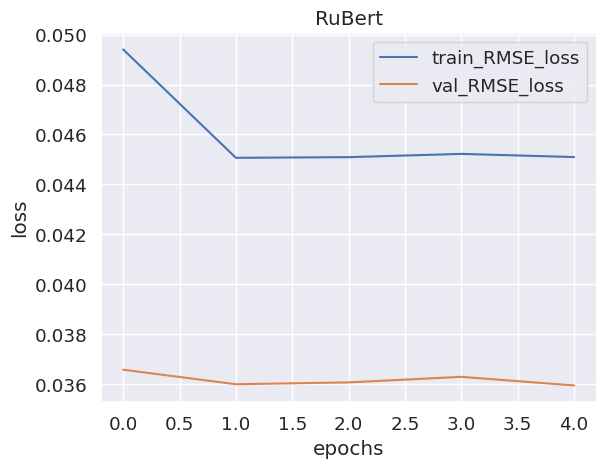

In [63]:
vizualize(graphs, 'RuBert')

In [64]:
0.03 ** .5

0.17320508075688773

## 🐋 CatBoost

In [102]:
def baseline(data: pd.DataFrame, columns: list, cat_features: list, target: list, save=False):
    x_train, x_val, y_train, y_val = train_test_split(data[columns], data[target], random_state=RANDOM_STATE)
    pool_train = Pool(x_train, y_train, cat_features=cat_features)
    pool_val = Pool(x_val, y_val, cat_features=cat_features)
    model = CatBoostRegressor(loss_function='RMSE')
    model.fit(pool_train, eval_set=pool_val, verbose=False, early_stopping_rounds=20)
    res = model.predict(pool_val)
    y_val["pr"] = res
    y_val["diff"] = - y_val["pr"] + y_val["target"]
    r2 = r2_score(y_val["target"], y_val["pr"])
    rmse_score = np.sqrt(mean_squared_error(y_val["target"], y_val["pr"]))
    mape_score = 100*mean_absolute_percentage_error(y_val["target"], y_val["pr"])
    plt.plot(y_val["target"], y_val["diff"], "x")
    plt.title(f'Residuals\nR2 score: {r2:.3f}\n'
              f'RMSE score: {rmse_score:.2f}\n'
              f'RMSE to target median ratio: {rmse_score / y_val["target"].median():.2f}\n'
              f'MAPE score: {mape_score:.2f} %')
    plt.show()
    importances = model.feature_importances_
    importances = pd.Series(importances, index=columns).sort_values(ascending=False)
    importances.plot.bar()
    plt.title("Feature importances")
    plt.ylabel("Mean decrease in impurity")
    plt.show()
    if save:
        name = f'{str(data.shape[0] * data.shape[1])}_cat.joblib'
        joblib.dump(model, name)

In [115]:
columns = df.columns.drop(['target', 'description'])
target = ['target']
cat_features = ['grade', 'profession', 'location', 'emp_brand']
text = ['description']

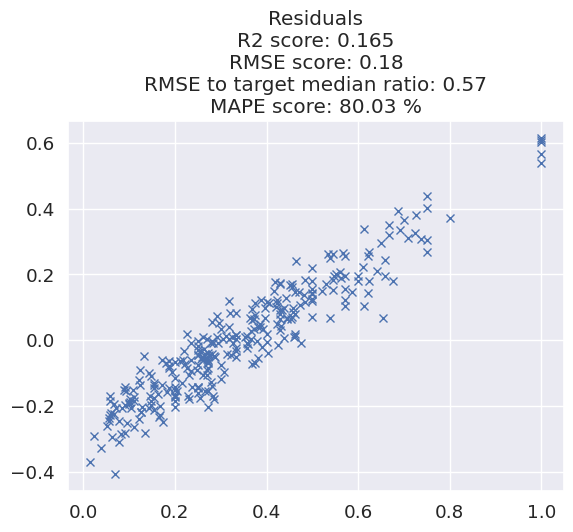

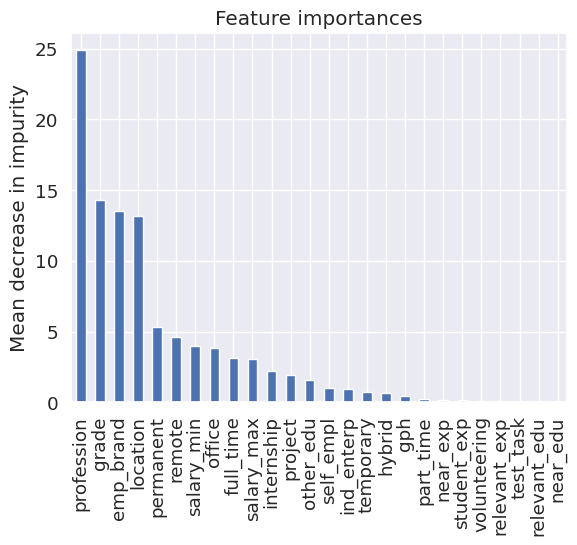

In [116]:
baseline(df, columns, cat_features, target)

In [103]:
# df2 = pd.concat([df.reset_index(drop=True), dfe], axis=1)
# columns = df2.columns.drop(['target', 'description'])
# target = ['target']
# cat_features = ['grade', 'profession', 'location']
# text = ['description']

# baseline(df2, columns, cat_features, target)

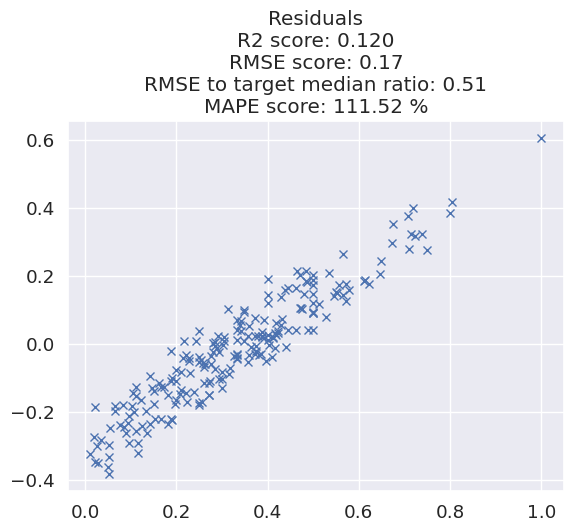

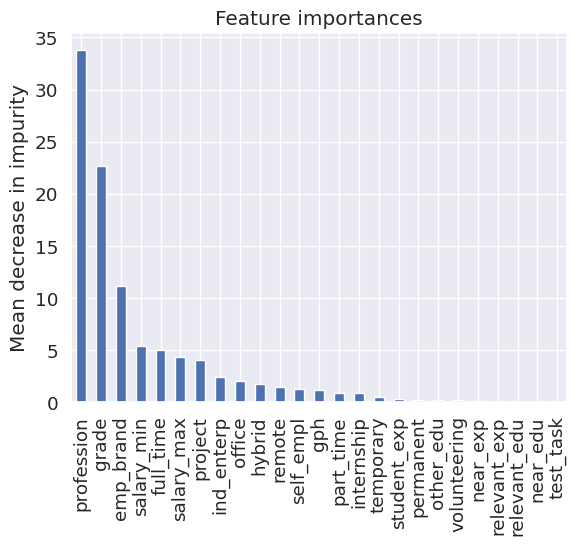

In [105]:
df2 = df.loc[df['location'] == 'MOW']
columns = df2.columns.drop(['target', 'description', 'location'])
target = ['target']
cat_features = ['grade', 'profession', 'emp_brand']

baseline(df2, columns, cat_features, target)

In [117]:
# for p in df['profession'].unique():
#    df1 = df.loc[df['profession'] == p]
#    columns = df1.columns.drop(['target', 'description', 'salary_min', 'salary_max', 'profession', 'location', 'grade'])
#    target = ['target']
#    cat_features = ['emp_brand']
#    print(p.upper(), '\n')
#    baseline(df1, columns, cat_features, target)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1170 entries, 0 to 1301
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   emp_brand     1170 non-null   object 
 1   salary_min    425 non-null    float64
 2   salary_max    1170 non-null   float64
 3   test_task     1170 non-null   int64  
 4   target        1170 non-null   float64
 5   grade         1170 non-null   object 
 6   profession    1170 non-null   object 
 7   location      1170 non-null   object 
 8   near_exp      1170 non-null   int64  
 9   student_exp   1170 non-null   int64  
 10  relevant_exp  1170 non-null   int64  
 11  other_edu     1170 non-null   int64  
 12  near_edu      1170 non-null   int64  
 13  relevant_edu  1170 non-null   int64  
 14  office        1170 non-null   int64  
 15  remote        1170 non-null   int64  
 16  hybrid        1170 non-null   int64  
 17  permanent     1170 non-null   int64  
 18  self_empl     1170 non-null   int

In [123]:
df['edu_opt'] = df['other_edu'] + df['near_edu'] + df['relevant_edu']
df['exp_opt'] = df['student_exp'] + df['near_exp'] + df['relevant_exp']
df['format_opt'] = df['office'] + df['remote'] + df['hybrid']
df['contract_opt'] = df['permanent'] + df['gph'] + df['self_empl'] + df['temporary'] + df['ind_enterp']
df['time_opt'] = df['part_time'] + df['full_time'] +df['internship'] + df['volunteering'] + df['project']

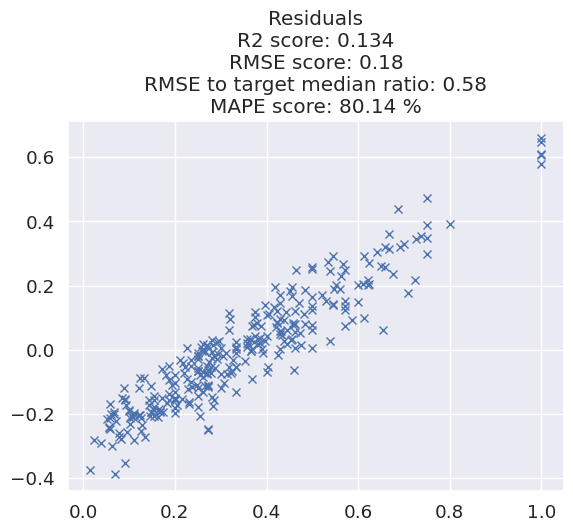

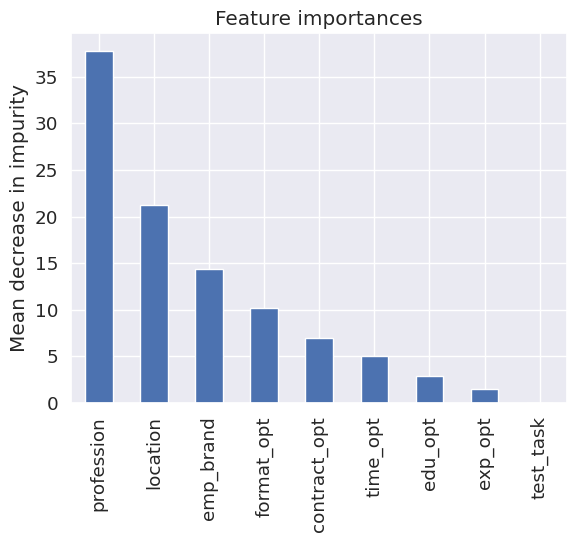

In [129]:
columns = ['emp_brand', 'test_task',
       'profession', 'location', 'edu_opt', 'exp_opt', 'format_opt', 'contract_opt', 'time_opt']
target = ['target']
cat_features = ['profession', 'emp_brand', 'location']

baseline(df, columns, cat_features, target)

## 🐠 Выводы


- R2-score низкий
- график остатков неприятный
- добавление эмбеддингов в катбуст картину не улучшает
- рассмотрение только москвы тоже принципиально лучше не делает
- предсказания bert-ом прироста в метрике не дают
- кластеризация по профессиям - тоже